### Overview

This notebook demos EDA on the features of IMDB movies from 2009-01-01 to 2019-10-31. The goal is to find some discriptive statistics for each field and find some relationship between movie's popularity and other features

### Dataset

We created our own dataset using IMDb's public datasets and the IMDbPY API to get the movies in recent 10 years on IMDB from 2009-01-01 to 2019-10-31 and each movie's title, release year, genre, plot summaries, the number of votes and rating. We will perform EDA on this dataset for demo purpose.

Source code can be found on Github: https://github.com/Zoe0409/Movie-plot-analysis-with-NLP/blob/master/dataset/Collect%20data%20from%20IMDB.ipynb. 

### Items to explore

1. Find the most popular key words
2. Try to understand relationship between a movie's number of votes and features
    - get votes distribution for different ratings
    - get votes distribution for different key words
    - get votes distribution for different genre
    - find relationship between votes and plot summary word counts

### Motivation

This will give us an insight about what the people’s preferences are for the different movie genres and keywords. These insights possibly are useful for the critics.

In [1]:
import sys
import os
import json
import numpy as np
import pandas as pd

import seaborn.apionly as sns
import matplotlib.pyplot as plt
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[ke

### load data

In [2]:
df = pd.read_csv("../dataset/movie_info.csv")
df['genre'] = [genre.split("|") for genre in df['genre']]
df['key words'] = [genre.split("|") for genre in df['key words']]

Take a look at the first 10 rows

In [3]:
df.head(10)

,title,release year,genre,key words,plot,run time /min,number of votes,rating
0,Sharknado,2013,"[Action, Adventure, Comedy, Horror, Sci-Fi, Th...","[school-bus, chainsaw, psychotronic-film, hurr...","When a freak hurricane swamps Los Angeles, nat...",86,44265,3.3
1,The Normal Heart,2014,"[Drama, History, Romance]","[gay, gay-men's-health-crisis, hiv, aids-epide...",A gay activist attempts to raise H.I.V. and A....,132,31793,7.9
2,The Sunset Limited,2011,[Drama],"[minimal-cast, dialogue-between-two-characters...","Through a chance encounter, two men of opposin...",91,26733,7.4
3,Temple Grandin,2010,"[Biography, Drama]","[cattle, animal-husbandry, livestock, autism, ...","A biopic of Temple Grandin, an autistic woman ...",107,25551,8.3
4,You Don't Know Jack,2010,"[Biography, Drama]","[suicide, assisted-suicide, moral-dilemma, mor...",A look at the life and work of doctor-assisted...,134,25404,7.6
5,Game Change,2012,"[Biography, Drama, History]","[american-politics, cell-phone, down-syndrome,...",Governor Sarah Palin of Alaska becomes Senator...,118,20092,7.4
6,Princess Protection Program,2009,"[Comedy, Drama, Family]","[princess, dictator, teenager, protection, lou...",A princess whose country has been invaded goes...,90,20083,5.6
7,Mean Girls 2,2011,[Comedy],"[sexiness, dream-girl, short-skirt, miniskirt,...",The Plastics are back in the long-awaited foll...,96,19579,4.1
8,The Wizard of Lies,2017,"[Biography, Crime, Drama]","[financial-fraud, financier, ponzi-scheme, fra...","The fall of Bernie Madoff, whose Ponzi scheme ...",133,19471,6.8
9,Sharknado 2: The Second One,2014,"[Action, Adventure, Comedy, Horror, Sci-Fi, Th...","[second-part, john-f.-kennedy-international-ai...",Fin and April are on their way to New York Cit...,95,17067,4.0


### Basic EDA

**Key Words**

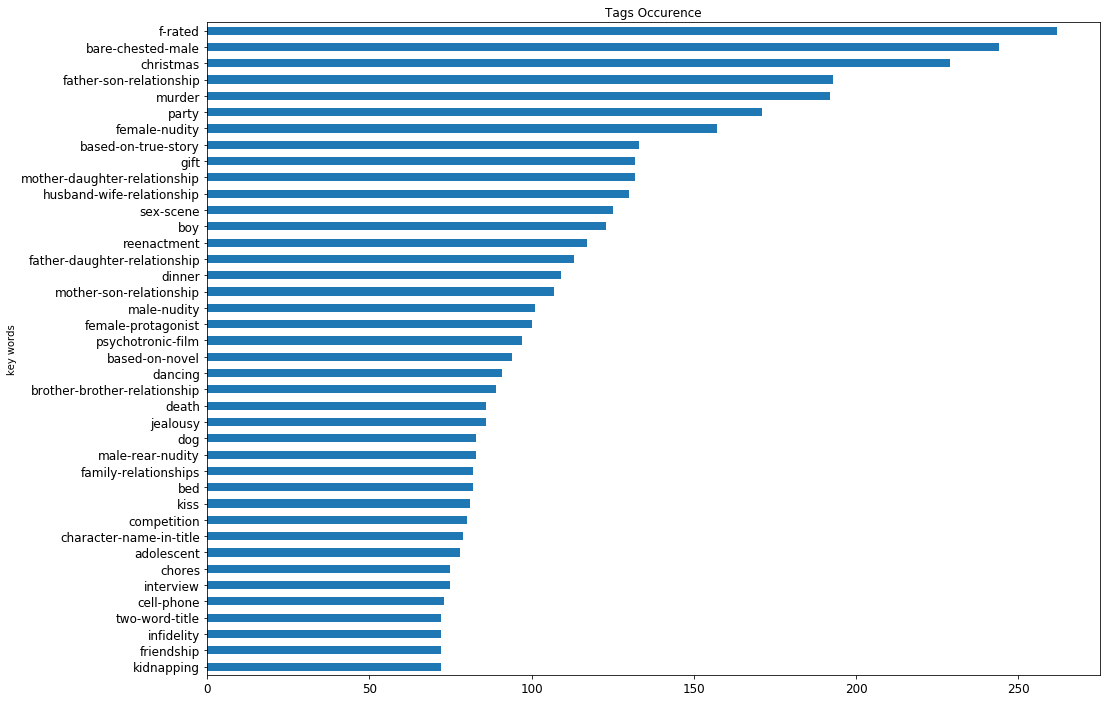

In [4]:
import itertools
keywords = list(itertools.chain(*df['key words'].values))
pd.DataFrame(keywords, columns=['key words'])\
    .groupby('key words')['key words']\
    .count()\
    .sort_values(ascending=False)[:40][::-1]\
    .plot(
        kind='barh',
        figsize=(16, 12),
        fontsize=12,
        title='Tags Occurence',
)

**Votes Analysis**

In [5]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [6]:
df_keywords = explode(df, ['key words']) 

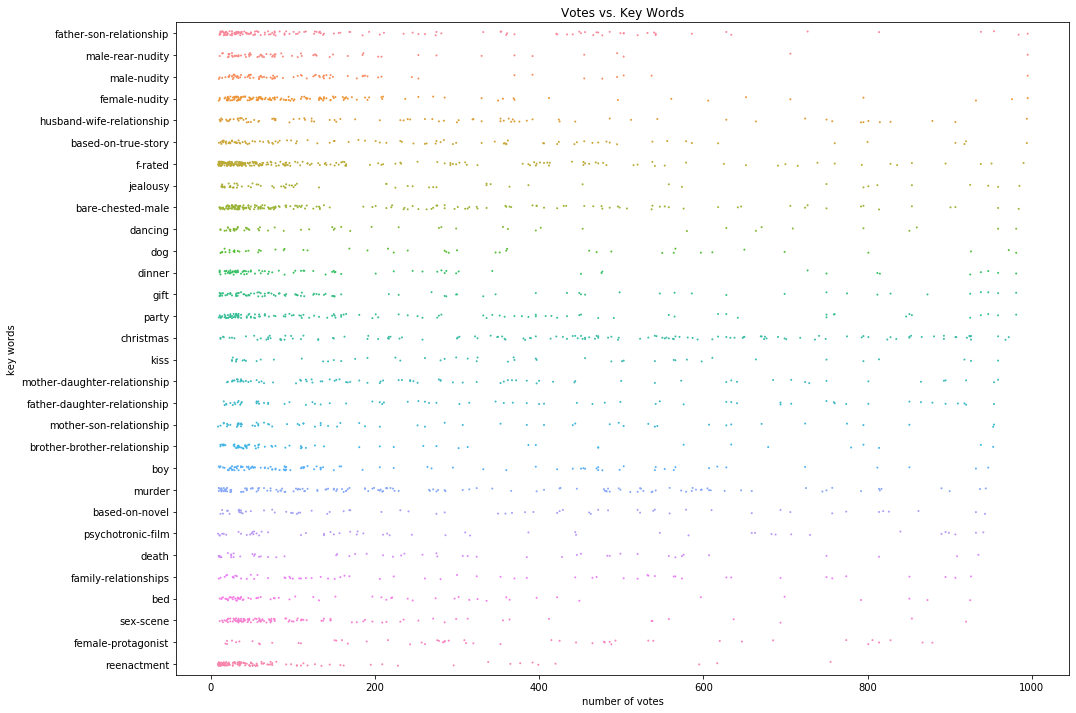

In [7]:
high_vol_key_words = df_keywords.groupby('key words')['key words']\
    .count()\
    .sort_values(ascending=False)[:30]\
    .index.values
high_vol_key_words_filter = df_keywords['key words'].isin(high_vol_key_words)

data = df_keywords[high_vol_key_words_filter.values]
data = data[data['number of votes']<=1e3]
f, ax = plt.subplots(figsize=(16, 12))
ax.set_title('Votes vs. Key Words', fontsize=12)
sns.stripplot(x= 'number of votes', y='key words', data=data, ax=ax, jitter=1, marker='.', size=4)

Based the plot above, movies with keyword "christmas" are more likely to get a relatively higer number of votes.

In [8]:
df_genre = explode(df, ['genre']) 

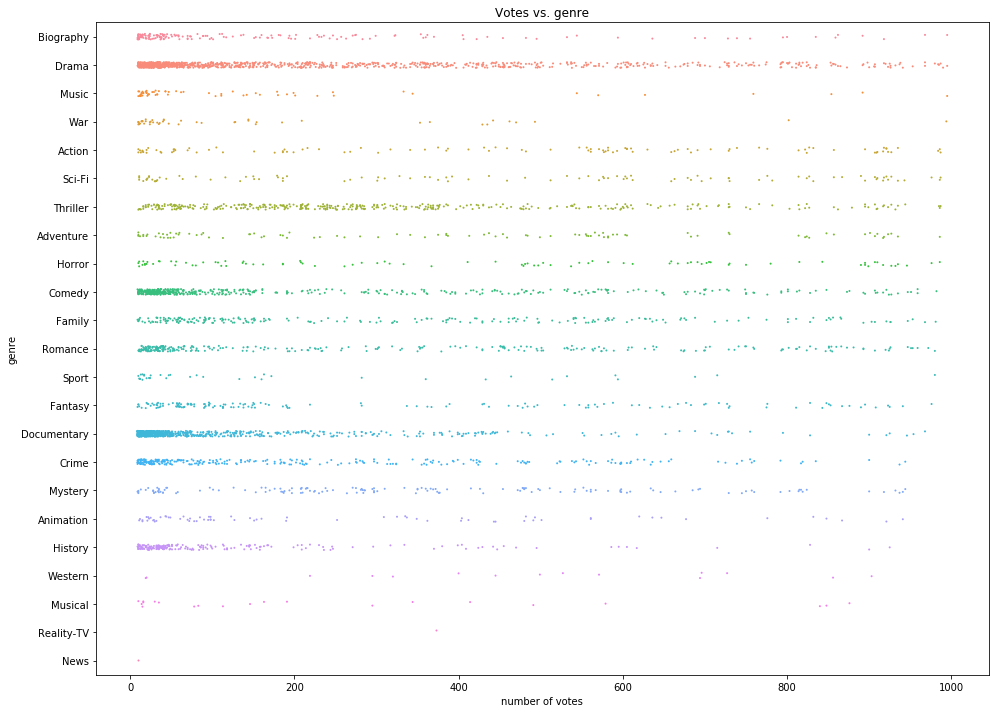

In [9]:
high_vol_genre = df_genre.groupby('genre')['genre']\
    .count()\
    .sort_values(ascending=False)[:30]\
    .index.values
high_vol_genre_filter = df_genre['genre'].isin(high_vol_genre)

data = df_genre[high_vol_genre_filter.values]
data = data[data['number of votes']<=1e3]
f, ax = plt.subplots(figsize=(16, 12))
ax.set_title('Votes vs. genre', fontsize=12)
sns.stripplot(x= 'number of votes', y='genre', data=data, ax=ax, jitter=1, marker='.', size=4)

Based the plot above, drama movies are more likely to get a relatively higer number of votes.

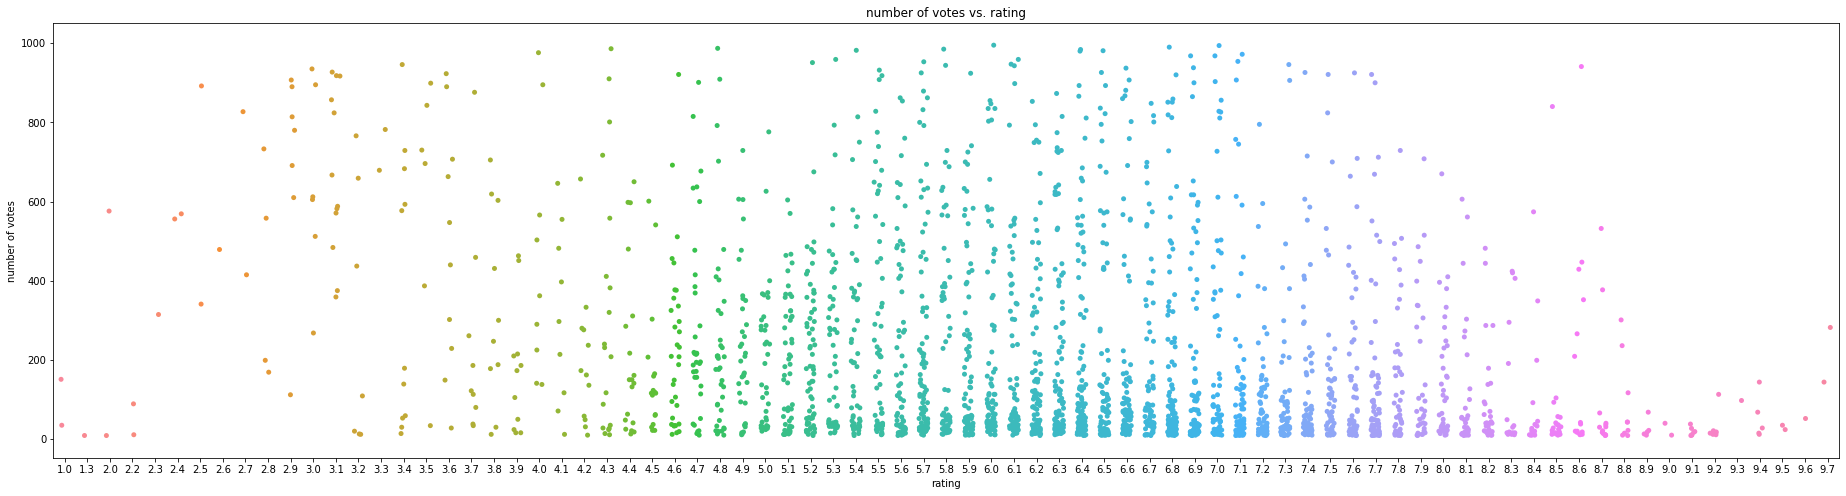

In [10]:
data = df[df['number of votes'] <= 1e3]
f, ax = plt.subplots(figsize=(32, 8))
ax.set_title('number of votes vs. rating', fontsize=12)
sns.stripplot(x='rating', y='number of votes', data=data, ax=ax, jitter=0.2)

Based the plot above, movies with the rating between 5.5 and 7.5 are more likely to get a relatively higer number of votes.